In [3]:
res = pd.read_pickle('/Users/nokni/work/MHDTurbPy/example/final_intervals/2018-11-05_20-06-00_2018-11-06_08-06-00_sc_0/final_data.pkl')

In [4]:
res = pd.read_pickle('/Users/nokni/work/MHDTurbPy/example/final_intervals/2018-11-05_20-06-00_2018-11-06_08-06-00_sc_0/final_data.pkl')

dfb = res['Mag']['B_resampled']
dfv = res['Par']['V_resampled']

In [5]:
dt_dfb  = pd.to_timedelta(pd.infer_freq(dfb.index)).total_seconds()
dt_dfv  = pd.to_timedelta(pd.infer_freq(dfv.index)).total_seconds()

In [13]:
import fractions
fractions.

SyntaxError: invalid syntax (3557219840.py, line 2)

In [ ]:
import pandas as pd
import numpy as np

# Load the timeseries data into a pandas DataFrame
df = pd.read_csv("solar_wind_data.csv")

# Remove any rows with missing values
df = df.dropna()

# Interpolate over gaps in the data
df = df.interpolate()

# Normalize the features
cols = df.columns[:-1] # exclude the distance from the Sun column
df[cols] = (df[cols] - df[cols].mean()) / df[cols].std()

# Normalize the distance from the Sun column
df["R"] = df["R"] / df["R"].max()

# Save the preprocessed data to a new file
df.to_csv("solar_wind_data_preprocessed.csv", index=False)


In [7]:
def resample(s, p, q, h=None):
    """Change sampling rate by rational factor. This implementation is based on
    the Octave implementation of the resample function. It designs the 
    anti-aliasing filter using the window approach applying a Kaiser window with
    the beta term calculated as specified by [2].
    
    Ref [1] J. G. Proakis and D. G. Manolakis,
    Digital Signal Processing: Principles, Algorithms, and Applications,
    4th ed., Prentice Hall, 2007. Chap. 6
    Ref [2] A. V. Oppenheim, R. W. Schafer and J. R. Buck, 
    Discrete-time signal processing, Signal processing series,
    Prentice-Hall, 1999
    """

    
    import math
    gcd = math.gcd(p, q)
    
    if gcd>1:
        p=p/gcd
        q=q/gcd
    
    if h is None: #design filter
        #properties of the antialiasing filter
        log10_rejection = -3.0
        stopband_cutoff_f = 1.0/(2.0 * max(p,q))
        roll_off_width = stopband_cutoff_f / 10.0
    
        #determine filter length
        #use empirical formula from [2] Chap 7, Eq. (7.63) p 476
        rejection_db = -20.0*log10_rejection;
        l = numpy.ceil((rejection_db-8.0) / (28.714 * roll_off_width))
  
        #ideal sinc filter
        t = numpy.arange(-l, l + 1)
        ideal_filter=2*p*stopband_cutoff_f*numpy.sinc(2*stopband_cutoff_f*t)  
  
        #determine parameter of Kaiser window
        #use empirical formula from [2] Chap 7, Eq. (7.62) p 474
        beta = signal.kaiser_beta(rejection_db)
          
        #apodize ideal filter response
        h = numpy.kaiser(2*l+1, beta)*ideal_filter

    ls = len(s)
    lh = len(h)

    l = (lh - 1)/2.0
    ly = numpy.ceil(ls*p/float(q))

    #pre and postpad filter response
    nz_pre = numpy.floor(q - numpy.mod(l,q))
    hpad = h[-lh+nz_pre:]

    offset = numpy.floor((l+nz_pre)/q)
    nz_post = 0;
    while numpy.ceil(((ls-1)*p + nz_pre + lh + nz_post )/q ) - offset < ly:
        nz_post += 1
    hpad = hpad[:lh + nz_pre + nz_post]

    #filtering
    xfilt = upfirdn(s, hpad, p, q)

    return xfilt[offset-1:offset-1+ly]

downsampled = pd.DataFrame(resample(dfb['Br'].values, dt_dfb, dt_dfv), index=dfv.index, columns=['a'])


TypeError: 'float' object cannot be interpreted as an integer

In [10]:
def gcd(p, q):
    while q != 0:
        p, q = q, p % q
    return p

gcd(dt_dfv, dt_dfb)

1.734723475976807e-18

In [ ]:
import numpy as np
import pandas as pd
import fractions
from scipy.signal import decimate, upfirdn, kaiser_beta, sinc

lenb = 5000
lenv = 200

dfb = pd.DataFrame({'a': np.arange(0, lenb, 1)}, index=pd.date_range('2022-01-01', periods=lenb, freq='2s'))
dfv = pd.DataFrame({'c': np.arange(0, lenv, 1)}, index=pd.date_range('2022-01-01', periods=lenv, freq='10s'))

downsampled = pd.DataFrame(resample(dfb['a'].values, 2, 10), index=dfv.index, columns=['a'])


In [65]:
    from scipy.signal import decimate

    def newindex(df, ix_new, interp_method='linear'):
        """
        Reindex a DataFrame according to the new index *ix_new* supplied.

        Args:
            df: [pandas DataFrame] The dataframe to be reindexed
            ix_new: [np.array] The new index
            interp_method: [str] Interpolation method to be used; forwarded to `pandas.DataFrame.reindex.interpolate`

        Returns:
            df3: [pandas DataFrame] DataFrame interpolated and reindexed to *ixnew*

        """

        # create combined index from old and new index arrays
        ix_com = np.unique(np.append(df.index, ix_new))

        # sort the combined index (ascending order)
        ix_com.sort()

        # re-index and interpolate over the non-matching points
        df2 = df.reindex(ix_com).interpolate(method=interp_method)

        # drop all the old index points by re-indexing to new index
        df3 = df2.reindex(ix_new)
        #print(len(df3)), print(len(ix_new))
        return df3


    def downsample_dataframe(dfb, dfv, filter_order=3):
        freq_dfb  = pd.infer_freq(dfb.index)
        freq_dfv  = pd.infer_freq(dfv.index)
        q         = int(pd.to_timedelta(freq_dfv).total_seconds()/pd.to_timedelta(freq_dfb).total_seconds())

        dfb_downsampled = pd.DataFrame()
        for column_name in dfb.columns:
            signal = dfb[column_name]
            signal = decimate(signal, q, zero_phase=True, axis=0, n=filter_order)
            dfb_downsampled[column_name] = signal

        # Create new index starting from dfb.index[0] with a cadence of freq_dfv
        new_index = pd.date_range(start=dfb.index[0], freq=freq_dfv, periods=len(signal))
        dfb_downsampled.index = new_index

        # Now reindex dfb to index of dfv
        dfb_downsampled = func.newindex(dfb_downsampled, dfv.index)
        return dfb_downsampled



    dfb_downsampled = downsample_dataframe(df_B, df_V, filter_order=3)

In [ ]:
plt

In [4]:
func.newindex(dfb_downsampled, dfv.index)

TypeError: newindex() missing 2 required positional arguments: 'df' and 'ix_new'

In [53]:
from fractions import Fraction
def irreducible_fraction(k):
    return Fraction(k).limit_denominator()


res=irreducible_fraction(3.45)

In [58]:
a,b= res.as_integer_ratio()

In [73]:
pd.infer_freq(df_B.index)

'10L'

In [79]:
new_df.index[-1]

Timestamp('2018-11-06 08:05:58.625000', freq='875L')

In [81]:
len(dfb_downsampled.index)

49370

In [82]:
len(new_df.index)

49370

In [66]:
from scipy import constants
mu_0            = constants.mu_0  # Vacuum magnetic permeability [N A^-2]
mu0             = constants.mu_0   #
m_p             = constants.m_p    # Proton mass [kg]

In [83]:
dates = [df_B['Br'].index[0], df_B['Br'].index[1000000]]
res    = func.find_ind_of_closest_dates (df_B, dates)
res2   = func.find_ind_of_closest_dates (dfb_downsampled, dates)
res3   = func.find_ind_of_closest_dates (new_df, dates)

28-Jan-23 08:39:17: /Users/nokni/work/MHDTurbPy/functions.py:1599: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indices.append(df.index.unique().get_loc(date, method='nearest'))



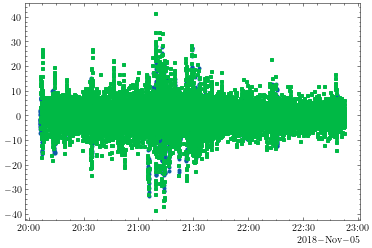

In [50]:
npp =df_V['np'][res2[0]:res2[1]].rolling('10min', center=True).mean()

plt.plot(1e-15*dfb_downsampled['Br'][res2[0]:res2[1]].diff(10)/np.sqrt(mu0*npp*m_p))
plt.plot(df_V['Vr'][res2[0]:res2[1]].diff(10))

In [84]:
new_df =func.newindex(df_B, df_V.index)

In [85]:
len(new_df['Br'][res3[0]:res3[1]].values)

11428

In [71]:
len( dfb_downsampled['Br'][res[0]:res[1]].values)

49370

In [89]:
np.corrcoef(new_df['Br'][res3[0]:res3[1]].values,new_df['Br'][res3[0]:res3[1]].values)

array([[1., 1.],
       [1., 1.]])

In [86]:
np.corrcoef(new_df['Br'][res3[0]:res3[1]].values, dfb_downsampled['Br'][res2[0]:res2[1]].values)

array([[1.        , 0.87787467],
       [0.87787467, 1.        ]])

In [62]:
new_df['Br'][res3[0]:res3[1]].values

array([-88.19435, -89.91099, -90.70445, ..., -90.62451, -91.93219,
       -92.47284], dtype=float32)

In [59]:
np.corrcoef(, )

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1000000 and the array at index 1 has size 11428

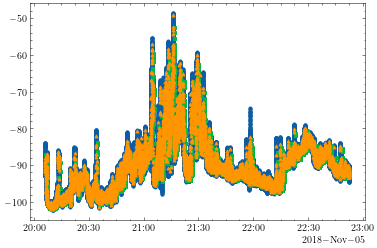

In [55]:
plt.plot(df_B['Br'][res[0]:res[1]])
plt.plot(dfb_downsampled['Br'][res2[0]:res2[1]])
plt.plot(new_df['Br'][res3[0]:res3[1]])

In [42]:
dj = 1/2

x = dfb_downsampled['Br'].values
y = dfb_downsampled['Bt'].values
z = dfb_downsampled['Bn'].values

dt = func.find_cadence(dfb_downsampled)
res1 = turb.trace_PSD_wavelet(x,y,z,dt, dj)

x = df_B['Br'].values
y = df_B['Bt'].values
z = df_B['Bn'].values

dt = func.find_cadence(df_B)
res2 = turb.trace_PSD_wavelet(x,y,z,dt, dj)

In [29]:
x = new_df['Br'].values
y = new_df['Bt'].values
z = new_df['Bn'].values

dt = func.find_cadence(new_df)
res3 = turb.trace_PSD_wavelet(x,y,z,dt, dj)

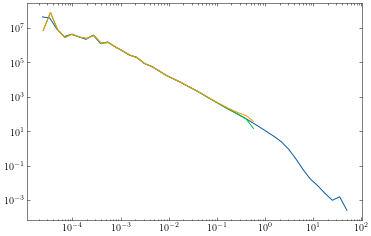

In [40]:
plt.loglog(res2[-3], res2[-2], ls='-', ms=0)
plt.loglog(res1[-3], res1[-2], ls='-', ms=0)
plt.loglog(res3[-3], res3[-2], ls='-', ms=0)

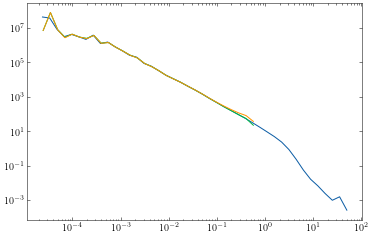

In [44]:
plt.loglog(res2[-3], res2[-2], ls='-', ms=0)
plt.loglog(res1[-3], res1[-2], ls='-', ms=0)
plt.loglog(res3[-3], res3[-2], ls='-', ms=0)

In [ ]:
final = downsample_dataframe(df_V, df_B,  filter_order=4)

KeyError: "None of ['DateTime'] are in the columns"

# Load libraries 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sys
import scipy.io
import os
import sys
from pathlib import Path
import pickle
from gc import collect
from glob import glob
from datetime import datetime
import traceback
from time import sleep
import matplotlib.dates as mdates


#Important!! Make sure your current directory is the MHDTurbPy folder!

os.chdir("/Users/nokni/work/MHDTurbPy/")
# SPEDAS API
# make sure to use the local spedas
sys.path.insert(0, os.path.join(os.getcwd(), 'pyspedas'))
import pyspedas
from pyspedas.utilities import time_string
from pytplot import get_data


""" Import manual functions """
#cd TurbPy
sys.path.insert(1, os.path.join(os.getcwd(), 'functions'))
import calc_diagnostics as calc
import TurbPy as turb
import general_functions as func
from   SEA import SEA

# Bettet figures
from matplotlib import pyplot as plt
plt.style.use(['science', 'scatter'])
plt.rcParams['text.usetex'] = True


This unreleased version of SpacePy is not supported by the SpacePy team.


# Download data
    - SCAM for PSP does not work great because it doesnt download all the files needed (Fix!)

In [ ]:
# Choose PSP or SolO
sc                      = 0                               # PSP:0, SolO:1

# If you only need to download 1 interval (dates wont matter if only_one_interval=0)
only_one_interval       = 1                               # If you only want to check one interval
starting_date           = '2018-11-05 20:06:00'           # Define starting and ending date of the interval
ending_date             = '2018-11-06 08:06:00'

# on the other hand if you have a list of intervals
load_path        = '/Users/nokni/work/MHDTurbPy/example/' # In case you have multiple days you want to download ()



choose_working_dir      = '/Users/nokni/work/sc_data/'    # Working dir. Usually where you save raw data (a psp_data, and/or solar_orbiter_data folder will be created)
save_path               = 'final_intervals/'              # This will be connected with the parent of load_path

#User defined parameters
subtract_rol_mean       = 1                               # To estimate fluctuations of mag, vel field
gap_time_threshold      = 5                               # Threshold for large gaps (units of seconds)
estimate_PSD            = 0                               # Estimate magentic field powes spectral density (keep false)
estimate_PSD_V          = 0                               # Estimate velocity field powes spectral density (keep false)
mag_resolution          = 10                              # Resample magnetic field timeseries in [ms] (at best, usually lower resolution depending on the interval)
high_res_mag            = 0                               # Use high resol or low resolution magnetic field data ( Choose either 1 or 0 respectively)
in_RTN                  = 1                               # RTN or spacecraft frame ( We will usually use RTN)
f_min_spec              = 2*1e-3                          # Integrate over [f_min_spec, f_max_spec]to estimate σc, σr 
f_max_spec              = 1e-2                            #
step                    = '12H'                           # Move starting point by step (in Hours)
duration                = '24H'                           # Duration of interval (in Hours)
settings                =  {
                            'particle_mode'      : 'empirical',                     
                            'use_hampel'         : False,
                            'interpolate_qtn'    : True,
                            'interpolate_rolling': True,
                            'verbose'            : False,
                            'must_have_qtn'      : False
                            } 
credentials              =  { 'psp':
                                  {
                                     'fields': {'username': 'none', 'password': 'none'},
                                     'sweap' : {'username': 'none', 'password': 'none'}
                                  }
                              }

# Change to to specified working dir
os.chdir(choose_working_dir)

if only_one_interval:
    df                      =  pd.DataFrame(    index = np.arange(1),
                                                data  = { 'Start' : pd.Timestamp(starting_date), 
                                                          'End'   : pd.Timestamp(ending_date)}
                                           )
else:
    df                      =  pd.read_pickle(load_path)

# Define final path
final_path              =  Path(load_path).joinpath(save_path)

# Run main loop
for ok in range(0,len(df)):
    # Print progress
    func.progress_bar(ok, len(df))

    t0 = df['Start'][ok]
    t1 = df['End'][ok]

    """Setup for main function"""
    tstarts, tends, tfmt, path0, settings   = calc.set_up_main_loop(final_path, settings, only_one_interval,t0, t1, step, duration, sc)

    # Load dist_df of SolO. Stupid way to do it fix later!!
    dist_df            = pd.read_pickle(str(Path(load_path).joinpath("ephem_data").joinpath("SolO_ephem.pkl")))

    """ Now run main for loop! """
    for i1 in range(len(tstarts)):
        start_time  = tstarts[i1]
        end_time    = tends[i1]
        
        # Define folder name
        foldername  = "%s_%s_sc_%d" %(str(start_time.strftime(tfmt)), str(end_time.strftime(tfmt)), 0)

        if not os.path.exists(path0.joinpath(foldername)):
            # Running the main function
            big_gaps, flag_good, final, general, sig_c_sig_r_timeseries = calc.final_func(
                                                                                          estimate_PSD_V   , 
                                                                                          subtract_rol_mean, 
                                                                                          settings,dist_df , 
                                                                                          start_time       ,
                                                                                          end_time         ,
                                                                                          f_min_spec       , 
                                                                                          f_max_spec       , 
                                                                                          estimate_PSD     , 
                                                                                          sc               , 
                                                                                          credentials      ,
                                                                                          high_res_mag     ,
                                                                                          in_RTN           ,
                                                                                          mag_resolution   , 
                                                                                          gap_time_threshold 
                                                                                         )
            if flag_good == 1:# (save...)

                if os.path.exists(path0.joinpath(foldername)):
                    print("%d out of %d finished" %(i1, len(df)))
                    continue
                try:
                    os.makedirs(path0.joinpath(foldername), exist_ok=True)

                    pickle.dump(final,open(path0.joinpath(foldername).joinpath("final_data.pkl"),'wb'))
                    pickle.dump(general,open(path0.joinpath(foldername).joinpath("general.pkl"),'wb'))

                except:
                    os.makedirs(path0.joinpath(foldername), exist_ok=True)
                    print("%s - %s failed!" %(i1, len(tstarts)))

                print("%d out of %d finished" %(i1, len(tstarts)))
            else:
                os.makedirs(path0.joinpath(foldername), exist_ok=True)
                print("%s - %s failed!" %(i1, len(tstarts)))            

# Visualize data

final resol 60000ms


24-Jan-23 02:24:09: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
24-Jan-23 02:24:13: /Users/nokni/work/MHDTurbPy/functions.py:1947: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



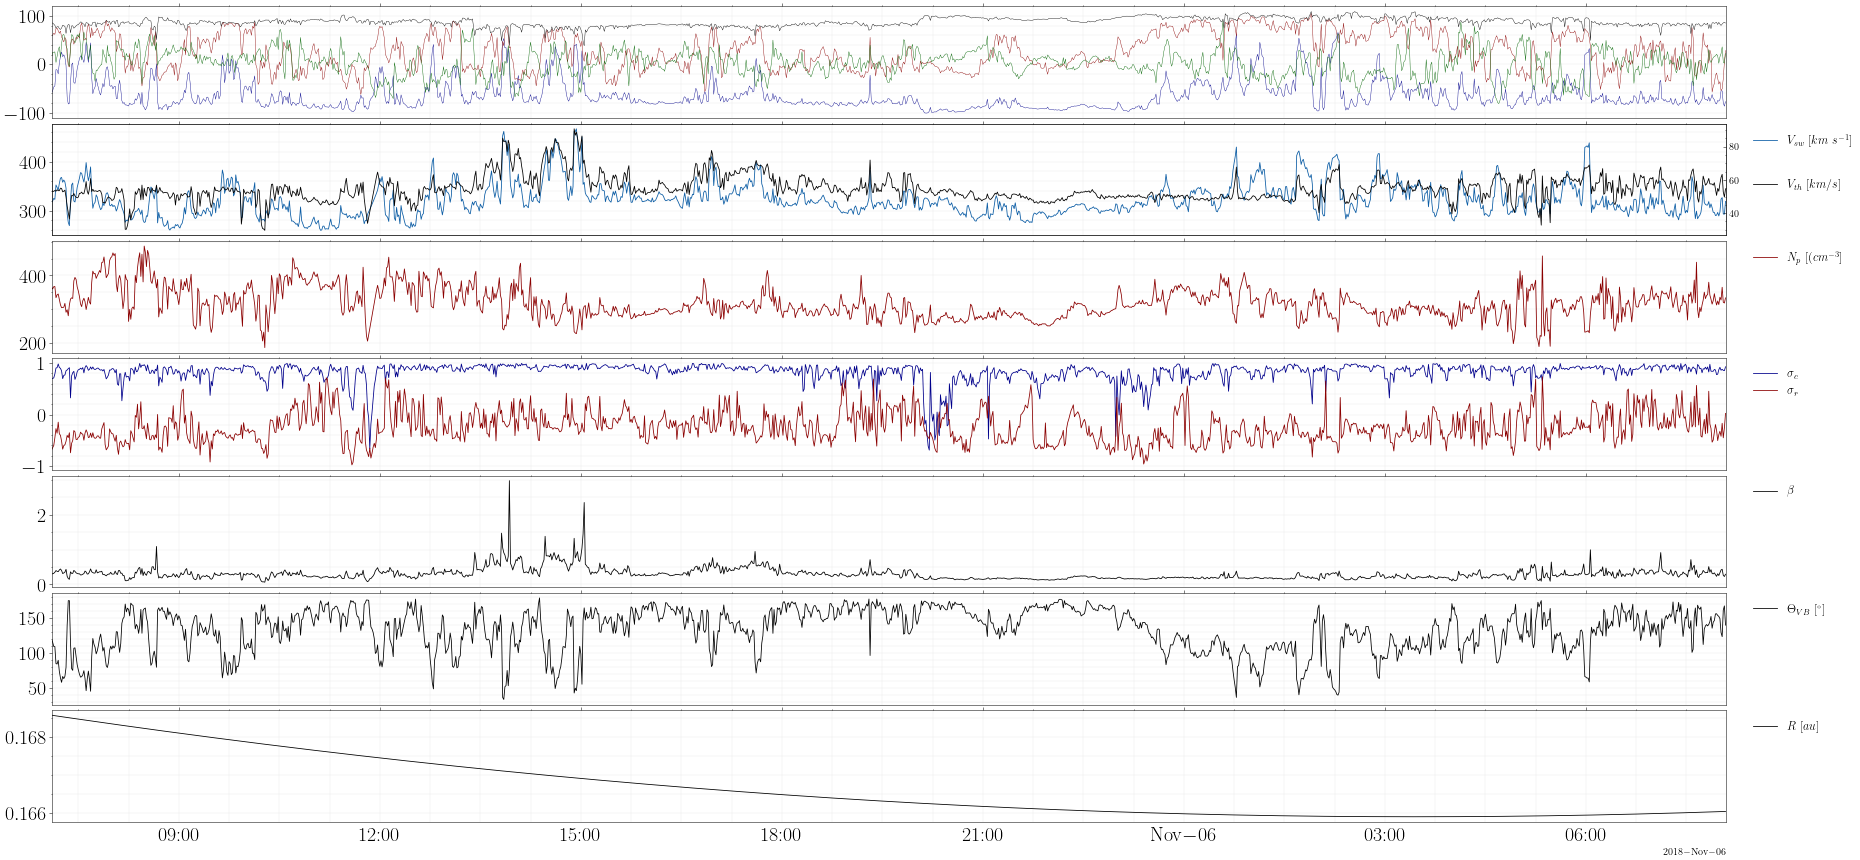

In [3]:
# user defined parameters
size              = 21                                    # labels etc
inset_f_size      = 20                                    # Not needed 
numb_subplots     = 7                                     # number os subplots
my_dir            = '/Users/nokni/work/MHDTurbPy/example' #
format_2_return   = "%Y_%m_%d"                            # Format to save figures
res_rate          = 60                                    # Resample timeseries [seconds]


func.visualize_downloaded_intervals(
                                  sc,
                                  final['Par']['V_resampled'],
                                  final['Mag']['B_resampled'],
                                  res_rate,
                                  my_dir,
                                  format_2_return ="%Y_%m_%d",  #
                                  size             = 21,
                                  inset_f_size     = 20,
                                  numb_subplots    = 7
                                 )

 

# Estimate Power Spectral Density (PSD) of the magnetic field.


In [ ]:
# User defined parameters
B_df                   = final['Mag']['B_resampled']
V_df                   = final['Par']['V_resampled']


# Morlet wavelet parameters
dj                     = 1/4
per_thresh, par_thresh = 80, 10

# Estimate cadence of mag field timeseries
dt                     = func.find_cadence(B_df)

# Estimate morlet-wavelet PSD. Also decompose into perp, parallel spectrumn
db_x, db_y, db_z, angles, VBangles, freqs, PSD, scales  = turb.estimate_wavelet_coeff(B_df,
                                                                                      V_df, 
                                                                                      dj , 
                                                                                      lambdaa=3
                                                                                     )
# Estimate perp and par spectra
PSD_par, PSD_per                                        = turb.estimate_PSD_wavelets_all_intervals(db_x, 
                                                                                                   db_y, 
                                                                                                   db_z, 
                                                                                                   VBangles.values, 
                                                                                                   freqs,   
                                                                                                   dt,  
                                                                                                   per_thresh, 
                                                                                                   par_thresh
                                                                                                  )

# Estimate FFT trace PSD
fft_freqs, fft_PSD                                      = turb.TracePSD(B_df.Br.values, 
                                                                        B_df.Bt.values, 
                                                                        B_df.Bn.values, 
                                                                        dt
                                                                       )

# Also provide smoothed FFT PSD (Using a window of size 2)
F_mid, F_mean,  smoothed_FFT_PSD                        = func.smoothing_function(fft_freqs, 
                                                                                  fft_PSD
                                                                                 )

# Plot PSD

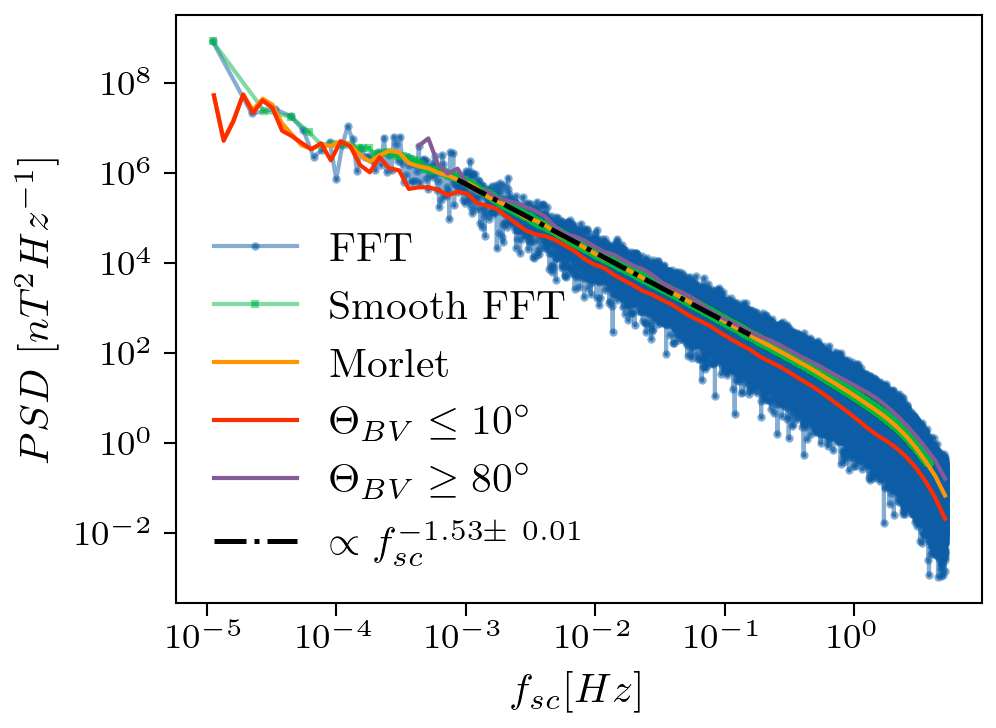

In [265]:
# Define limits of p-law fit
x0, xf                 = 8e-4, 2e-1
inset_f_size           = 10



# Define figure labels
ylabel, xlabel = r'$PSD~ [nT^{2} Hz^{-1}]$', r"$f_{sc} [Hz]$"


# init Figure
fig, ax  =func.initializeFigure(ylabel, xlabel, '1col')
minor_tick_params, major_tick_params = func.inset_axis_params(size = inset_f_size)


# Plot Trace FFT PSD
ax.loglog(fft_freqs, fft_PSD, ls='-', ms=1, alpha=0.5, label ='FFT')
# Plot  smoothed Trace FFT PSD
ax.loglog(F_mean,   smoothed_FFT_PSD, ls='-', ms=1, alpha=0.5, label ='Smooth FFT')

# Plot morlet wavelet PSD
ax.loglog(freqs, PSD,ls='-',ms=0, label ='Morlet')

# Plot morlet prallel wavelet PSD,
leg_par =r'$\Theta_{BV} \leq {%d}^{\circ} $'  %(par_thresh)
ax.loglog(freqs, PSD_par,ls='-',ms=0, label =leg_par)

# Plot morlet perpendicular wavelet PSD
leg_per =r'$\Theta_{BV} \geq {%d}^{\circ} $'  %(per_thresh)
ax.loglog(freqs, PSD_per,ls='-',ms=0, label =leg_per)

# Apply p-law fit on 
fit1, s1, e1, x1, y1  = func.find_fit(freqs,PSD, x0, xf)
# Define legend
lab_name =r'$\propto  f_{sc}^{ {%.2f}  \pm \ {%.2f}  }$'  %(round(fit1[0][1],2), round(np.sqrt(fit1[1][1][1]),2))

ax.loglog(x1[s1:e1],fit1[2], 'k-.', lw=1.2,label=lab_name)


# axins2 = ax.inset_axes([0.64, 0.61, 0.35, 0.35])
# axins2.yaxis.set_label_position("left")
# axins2.xaxis.set_label_position("bottom")
# axins2.yaxis.tick_left()
# axins2.xaxis.tick_bottom()

# axins2.tick_params(**minor_tick_params)
# axins2.tick_params(**major_tick_params)


ax.legend()

# Estimate PVI Timseries

(0.0, 19.69747589956187)

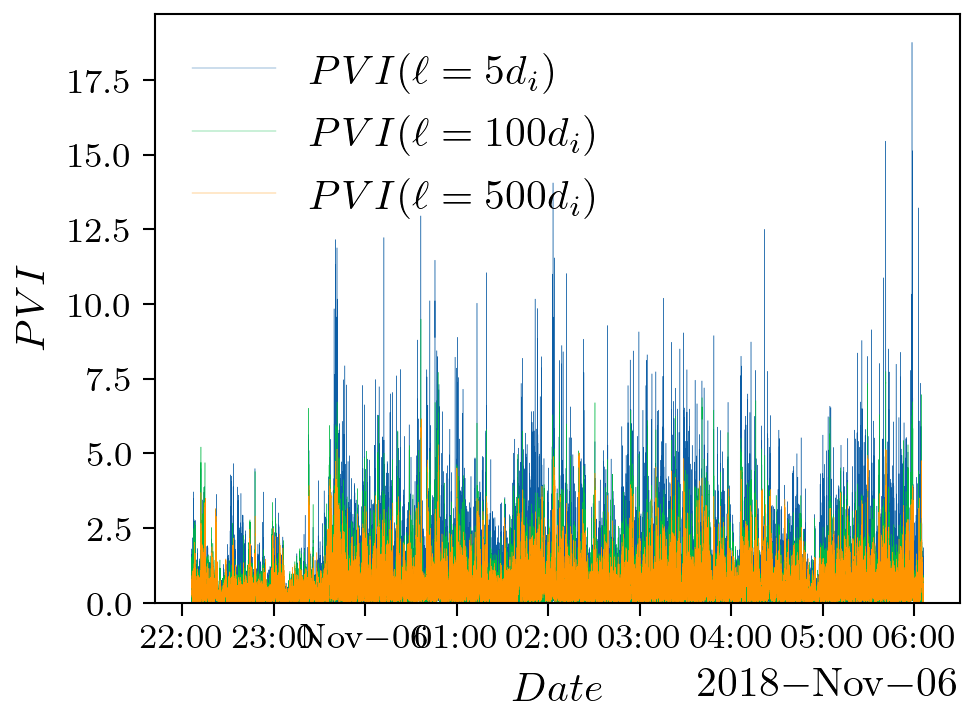

In [111]:
# User defined parameters
hours                  = 4                             # Averaging window in denominator (Hours)
hmany                  = [5, 100, 500]               # Estimate PVI timeseries using a lag of \ell =hmany*di
B_df                   = final['Mag']['B_resampled']
V_df                   = final['Par']['V_resampled']

#
di                     = final['Par']['di_mean']       # Mean value of ion inertial length for the interval
Vsw                    = final['Par']['Vsw_mean']      # Mean value of Solar wind speed  for the interval

# Define figure labels
ylabel, xlabel         = r'$PVI$',  r"$Date$"
inset_f_size           = 7



# Run function
PVI_ts                 =turb.estimate_PVI(B_df,
                                           hmany, 
                                           di,
                                           Vsw,
                                           hours,
                                           PVI_vec_or_mod='vec'
                                          )


# init Figure
fig, ax  =func.initializeFigure(ylabel, xlabel, '1col')

for kk in range(len(hmany)):
    ax.plot(PVI_ts['PVI_'+str(hmany[kk])], ls='-', ms=0, lw=0.1, label =r'$PVI(\ell= {%d} d_{i})$'%(hmany[kk]))
    
    # # Estimate PDF of PVI
    # res =func.pdf(PVI_ts['PVI_'+str(hmany[kk])].dropna().values, nbins, loglog, density)
    # ax2.semilogy(res[0], res[1], ls='-', ms=0, lw=0.1,c ='C'+str(kk))
    # ax2.set_ylabel(r'$p(PVI)$')
    # ax2.set_ylabel(r'$PVI$')
    


ax.legend(loc=0, )
ax.set_ylim([0,None])


# Superposed epoch analysis
- For more information check (https://github.com/nsioulas/SEA)

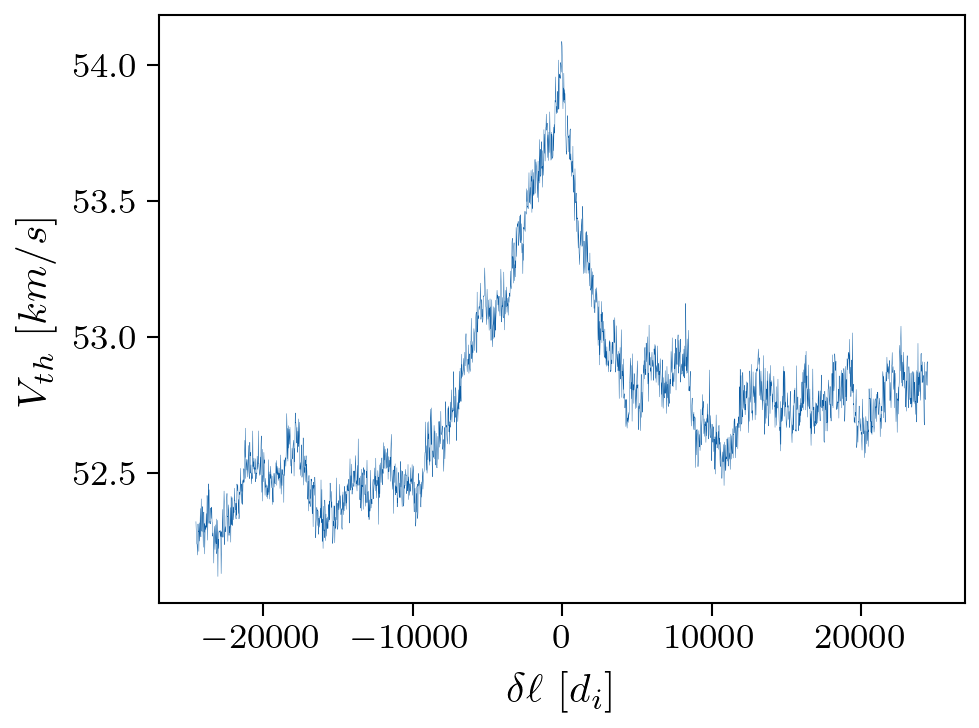

In [127]:
# user defined parameters
time_around        = '1000s'
which_one          =  'Vth'
mean_or_median     =  0
resample_rate      =  '800ms'

# you can actually aplly multiple conditions
condit_variables   = ['PVI_5']#, 'sigma_r']
conditions         = [['>=']]#, ['>=','<='] ]
threshold_values   = [[1]]#, [-0.15, 0.1]]


ylabel, xlabel     = r'$V_{th} ~[km/s]$',  r"$\delta \ell ~[d_i]$"


# Merge the two dfs
f_df = PVI_ts.resample(resample_rate ).mean().join(
     V_df.resample(resample_rate ).mean()
)


# run SEA function
xvals, yvals, y_std, y_std_err_mean  = SEA(f_df,
                                          condit_variables,
                                          threshold_values,
                                          conditions,
                                          time_around,
                                          which_one,
                                          mean_or_median,
                                          resample_rate)



# convert temporal lag to spatial and normalize with di
di_lag = Vsw*xvals/di

# init Figure
fig, ax  =func.initializeFigure(ylabel, xlabel, '1col')

ax.plot(di_lag, yvals, ls='-', ms=0, lw=0.1)
    